In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import diff_classifier.aws as aws
import diff_classifier.utils as ut
import diff_classifier.msd as msd
import diff_classifier.features as ft
import diff_classifier.imagej as ij
import diff_classifier.heatmaps as hm

import scipy.stats as stats
import os
import os.path as op
import numpy as np
import numpy.ma as ma
import pandas as pd
import itertools

In [2]:
radius = [4.5, 6.0, 7.0]
do_median_filtering = [True, False]
quality = [1.5, 4.5, 8.5]
linking_max_distance = [6.0, 10.0, 15.0]
gap_closing_max_distance = [6.0, 10.0, 15.0]
max_frame_gap = [1, 2, 5]
track_displacement = [0.0, 10.0, 20.0]

sweep = [radius, do_median_filtering, quality, linking_max_distance, gap_closing_max_distance, max_frame_gap,
         track_displacement]
all_params = list(itertools.product(*sweep))

In [3]:
pd_outputs = pd.read_csv('../../sensitivity/sensitivity_analysis.csv', delimiter=',', index_col='Unnamed: 0')

# Parameter Analysis

In [4]:
pd_outputs[(pd_outputs['radius']==4.5) &
     (pd_outputs['mean filter']==1.0) &
     (pd_outputs['quality']==4.5) &
     (pd_outputs['linking max D']==10.0) &
     (pd_outputs['gap closing max D']==10.0) &
     (pd_outputs['max frame gap']==2.0) &
     (pd_outputs['track displacement']==10.0)]

,radius,mean filter,quality,linking max D,gap closing max D,max frame gap,track displacement,MSD,particles
121,4.5,1.0,4.5,10.0,10.0,2.0,10.0,1.810576,1577.0


In [27]:
#Change in radius
counter = 0
dN = []
dMSD = []
for gapD in gap_closing_max_distance:
    for gap in max_frame_gap:
        for link in linking_max_distance:
            for qua in quality:
                for rad in radius:
                    for filt in do_median_filtering:
                    #for disp in track_displacement:
                        currentMSD = pd_outputs[(pd_outputs['radius']==rad) &
                                         (pd_outputs['mean filter']==filt) &
                                         (pd_outputs['quality']==qua) & 
                                         (pd_outputs['linking max D']==link) & 
                                         (pd_outputs['gap closing max D']==gapD) & 
                                         (pd_outputs['max frame gap']==gap)]['MSD'].as_matrix()
                                         #(pd_outputs['track displacement']==disp)]['MSD'].as_matrix()
                        dMSD.append((np.exp(currentMSD[-1]) - np.exp(currentMSD[0]))/
                                    (track_displacement[-1]-track_displacement[0]))
                        
                        currentN = pd_outputs[(pd_outputs['radius']==rad) &
                                         (pd_outputs['mean filter']==filt) &
                                         (pd_outputs['quality']==qua) & 
                                         (pd_outputs['linking max D']==link) & 
                                         (pd_outputs['gap closing max D']==gapD) & 
                                         (pd_outputs['max frame gap']==gap)]['particles'].as_matrix()
                                         #(pd_outputs['track displacement']==disp)]['particles'].as_matrix()
                        dN.append((currentN[-1] - currentN[0])/
                                  (track_displacement[-1]-track_displacement[0]))
                        
                        counter = counter + 1

#np.asarray(dMSD)

In [28]:
print('Mean dMSD is {} +/- {}'.format(np.mean(dMSD), stats.sem(dMSD)))
print('Mean dN is {} +/- {}'.format(np.mean(dN), stats.sem(dN)))

Mean dMSD is -1.3633173410232767e-06 +/- 3.4782707627764847e-06
Mean dN is -143.073353909465 +/- 4.9956501622941145


In [ ]:
pd_outputs[(pd_outputs['radius']==rad) &
                                        
                                         (pd_outputs['quality']==qua) & 
                                         (pd_outputs['linking max D']==link) & 
                                         (pd_outputs['gap closing max D']==gapD) & 
                                         (pd_outputs['max frame gap']==gap) &
                                         (pd_outputs['track displacement']==disp)]['MSD']

In [29]:
index=['radius', 'quality', 'linking', 'gap D', 'f gap', 'disp', 'filt']
sensitivity = {'Mean': np.array([-0.138288, -0.123315, 0.01131, 0.001849, 0.067573, 0.0000, 0.0990622]),
               'SEM': np.array([0.0043896, 0.0019237, 0.000901, 0.0008566, 0.002759, 0.00000, 0.0074249])}
df = pd.DataFrame(data=sensitivity, index=index)

In [36]:
index=['radius', 'quality', 'linking', 'gap D', 'f gap', 'disp', 'filt']
sensitivity = {'Mean': np.array([-498.76, -271.892, -6.24, -18.88, -171.39, -143.07, -0.017437]),
               'SEM': np.array([33.80, 13.963, 1.54, 2.27, 14.19, 5.00, 0.0012713])}
df = pd.DataFrame(data=sensitivity, index=index)

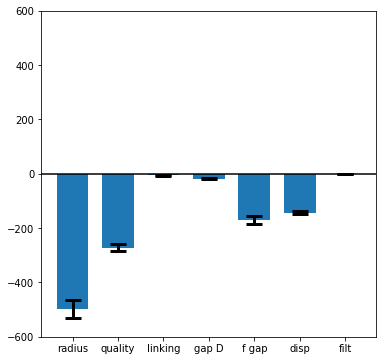

In [37]:
width = 0.7
ra = 600
fig = plt.figure(figsize=(6, 6))
p1 = plt.bar(index, df['Mean'], width=width, yerr=df['SEM'], capsize=8, error_kw={'elinewidth':3, 'capthick':3})

plt.axhline(y=0, color='k')
plt.ylim(-ra, ra)
plt.savefig('parameter_sensitivity_part.png', bbox_inches='tight')

In [ ]:
aws.upload_s3('parameter_sensitivity.png', '{}/parameter_sensitivity.png'.format(s_folder))

In [ ]:
frames = 651
fps = 100.02
t = np.linspace(0, frames-1, frames)/fps

fig = plt.figure(figsize=(10, 10))
for counter in range(0, len(all_params)):
    try:
        geo_file = 'geomean_{}_{}.csv'.format(name.split('.')[0], counter)
        aws.download_s3('{}/{}'.format(s_folder, geo_file), geo_file)
        gmean1 = np.genfromtxt(geo_file)
        os.remove(geo_file)
        
        plt.plot(t, np.exp(gmean1), 'k', linewidth=2, alpha=0.05)
    except:
        params = all_params[counter]
        print("Missing data {}".format(params))

plt.xlim(0, 1)
plt.ylim(0, 20)
plt.xlabel('Tau (s)', fontsize=25)
plt.ylabel(r'Mean Squared Displacement ($\mu$m$^2$/s)', fontsize=25)
plt.savefig('MSD_sweep.png', bbox_inches='tight')
aws.upload_s3('MSD_sweep.png', '{}/MSD_sweep.png'.format(s_folder))